In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from models import BatchPreparation, NonlinearComponentAnalysis, CCA
import matplotlib.pyplot as plt
import time
import os
from TwoChannelModel import *
from tqdm.notebook import tqdm

In [3]:
keys = time.asctime(time.localtime(time.time())).split()

# Please change your folder
path = '/volatile/mkuschel/nmca/' + str('-'.join(keys[0:3]))


try:
    os.makedirs(path)
    print(f'Path: {path} exists: {os.path.exists(path)}\n\n')
except:
    pass

In [4]:
rhos = [0.9, 0.75, 0.0]
batch_size = 1024
samples = 1024
z_dim = 2
c_dim = 3
num_views = 2
epochs = 5000
assert z_dim == 2


autoencoder_dims = [(1, None), (256, 'relu'), (1, None)]

----- TwoChannelModel -----



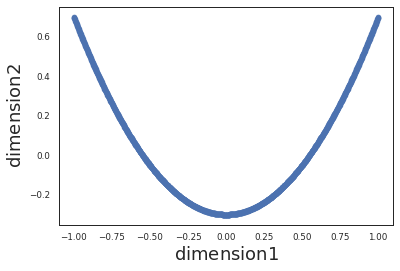

self.TC_y (1024, 5)
That are the computed correlations: [1. 1. 0. 0. 0.]


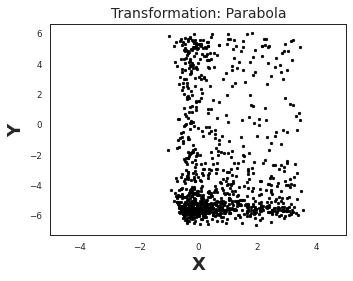

Generated Signal of Dimensions 5 X 1024 

Rows of Mixing Matrices: 5
Columns of Mixing Matrices: 5

Rows of Source Matrices: 5
Columns of Source Matrices: 1024



In [5]:
# Choose Parabola or Gaussian for relationship between the latent sources
# If transformation = True => Y = g(As) where g is a non-linear function
TCM = TwoChannelModel(
    path=path,
    observations=samples,
    mixing_dim=int(z_dim + c_dim),
    shared_dim=z_dim,
    private_dim=c_dim,
    mode='Parabola',
    transformation=True,
    rhos=rhos)

X, Y, S_x, S_y, created_rhos = TCM.getitems()

In [6]:
batched_X = BatchPreparation(batch_size=batch_size, samples=samples, data=X)
batched_Y = BatchPreparation(batch_size=batch_size, samples=samples, data=Y)
assert tf.shape(batched_X)[2] == tf.shape(batched_Y)[2]
assert batch_size == tf.shape(batched_X)[2]

batch_dims = tf.shape(batched_X)[0]
data_dim = tf.shape(batched_X)[1]

In [7]:
NCA_Class = NonlinearComponentAnalysis(num_views=num_views,
                                 num_channels=z_dim+c_dim,
                                 encoder_layers=autoencoder_dims,
                                 decoder_layers=autoencoder_dims,
                                 batch_size=batch_size)
NCA_Model = NCA_Class.NCA

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
View_0_Input_Encoder_Layer_Chan [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
View_0_Input_Encoder_Layer_Chan [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
View_0_Input_Encoder_Layer_Chan [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
View_0_Input_Encoder_Layer_Chan [(None, 1024, 1)]    0                                            
______________________________________________________________________________________________

In [8]:
chunkX = tf.transpose(batched_X[0])
chunkY = tf.transpose(batched_Y[0])
chunkXandY = tf.concat([chunkX, chunkY], 1)

data_chunk = [chunkXandY[:,i][None] for i in range(2*data_dim)]

loss_arr = list()
for epoch in tqdm(range(epochs), desc='Epochs'):
    with tf.GradientTape() as tape:
        tape.watch(data_chunk)
        output_of_encoders, output_of_decoders = NCA_Model(data_chunk)

        c_loss = NCA_Class.loss(output_of_encoders[0][0], output_of_encoders[1][0],
                              output_of_decoders[0][0], output_of_decoders[1][0],
                              chunkX, chunkY, batch_size, z_dim)
        loss_arr.append(c_loss)

    gradients = tape.gradient(c_loss, NCA_Model.trainable_variables)

    NCA_Class.optimizer.apply_gradients(zip(gradients, NCA_Model.trainable_variables))

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

## Loss

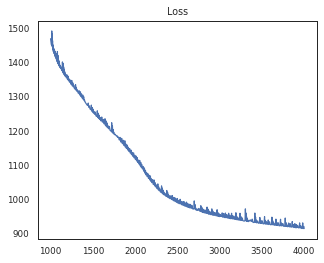

In [9]:
offset = int(len(loss_arr)*0.2)
plt.plot(np.squeeze([np.linspace(offset, len(loss_arr[offset:])-1, len(loss_arr[offset:]))]), loss_arr[offset:])
plt.title(r'Loss')
plt.show()

# Evaluation

In [10]:
eval_data_np, test_sample, S_x, S_y = TCM.eval(batch_size, z_dim+c_dim, data_dim)
eval_data_tf = tf.convert_to_tensor(eval_data_np, dtype=tf.float32)
output_of_encoders, output_of_decoders = NCA_Model([eval_data_tf[i] for i in range(2*data_dim)])

## Decoder-Encoder 

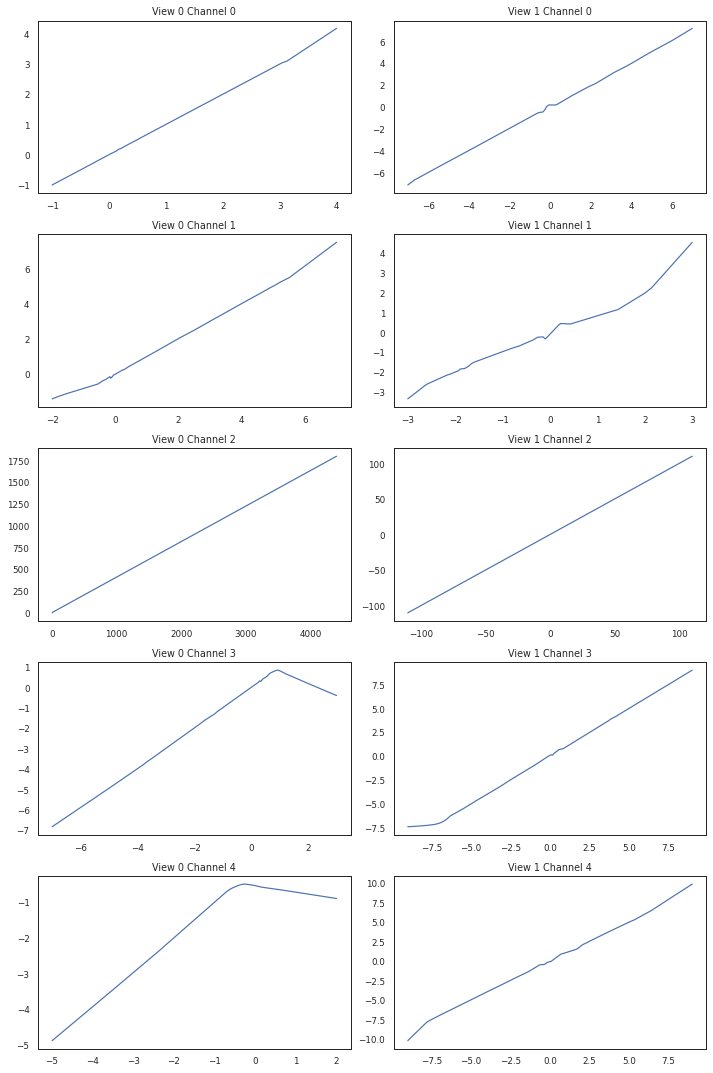

In [11]:
fig, axes = plt.subplots(z_dim+c_dim, num_views, figsize=(10, 15))

for c in range(z_dim+c_dim):
    for v in range(num_views):
        axes[c, v].title.set_text(f'View {v} Channel {c}')
        axes[c, v].plot(eval_data_np[v*5+c, 0], output_of_decoders[v][0,:,c])

plt.tight_layout()
plt.show()

## Inverse-Learning

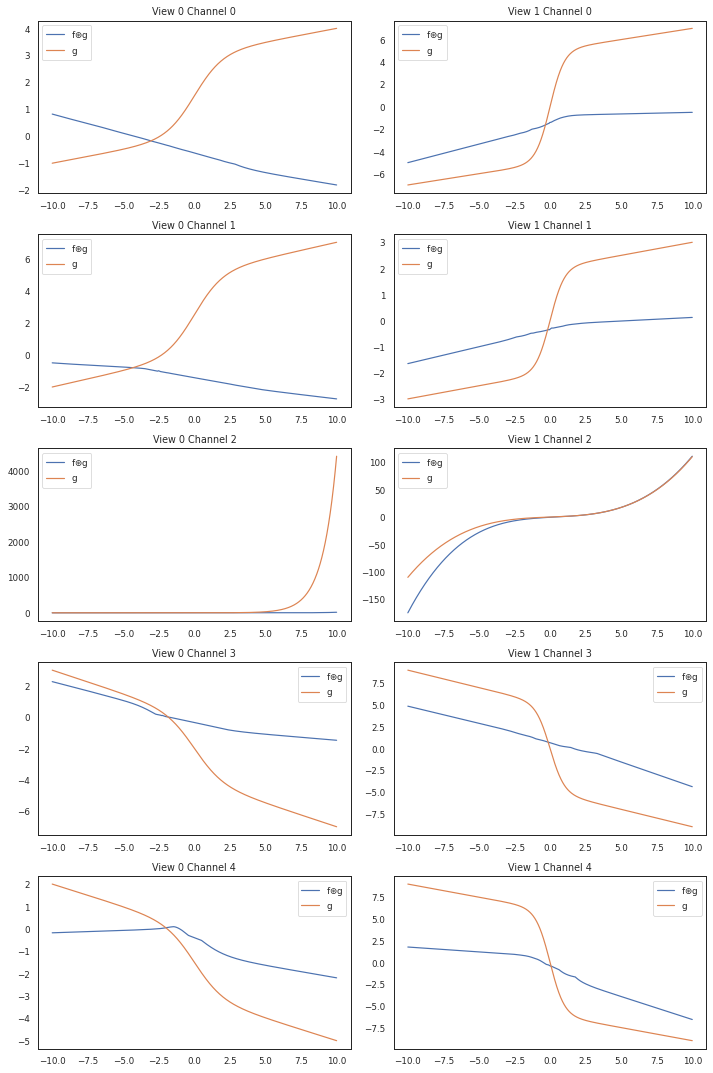

In [12]:
fig, axes = plt.subplots(z_dim+c_dim, num_views, figsize=(10, 15))

for c in range(z_dim+c_dim):
    for v in range(num_views):
        axes[c, v].title.set_text(f'View {v} Channel {c}')
        axes[c, v].plot(test_sample, output_of_encoders[v][0][:, c].numpy(),
                        label=r'$\mathrm{f}\circledast\mathrm{g}$')
        if v == 0:
            axes[c, v].plot(test_sample, np.squeeze(eval_data_np[:5][c]), label=r'$\mathrm{g}$')
        elif v == 1:
            axes[c, v].plot(test_sample, np.squeeze(eval_data_np[5:][c]), label=r'$\mathrm{g}$')

        axes[c, v].legend()

plt.tight_layout()
plt.show()

## Relation of estimated sources

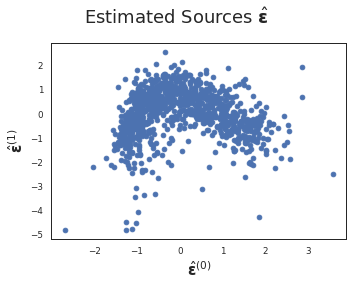

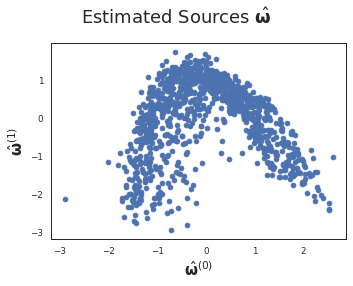

In [13]:
plt.scatter(NCA_Class.est_sources[0][0], NCA_Class.est_sources[0][1])
plt.ylabel(r'$\hat{\mathbf{\varepsilon}}^{(1)}$', fontsize='15')
plt.xlabel(r'$\hat{\mathbf{\varepsilon}}^{(0)}$', fontsize='15')
plt.suptitle(r'Estimated Sources $\hat{\mathbf{\varepsilon}}$', fontsize='18')
plt.tight_layout()
plt.show()

plt.scatter(NCA_Class.est_sources[1][0], NCA_Class.est_sources[1][1])
plt.ylabel(r'$\hat{\mathbf{\omega}}^{(1)}$', fontsize='15')
plt.xlabel(r'$\hat{\mathbf{\omega}}^{(0)}$', fontsize='15')
plt.suptitle(r'Estimated Sources $\hat{\mathbf{\omega}}$', fontsize='18')
plt.tight_layout()
plt.show()

## CCA values

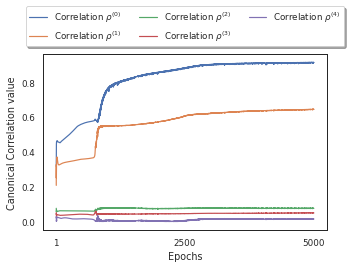

In [14]:
x_axis = np.linspace(1, epochs, epochs)
corrs = len(NCA_Class.can_corr[0])
labels = [r'Correlation $\rho^{(' + str(i) + ')}$' for i in range(corrs)]
plt.plot(x_axis, NCA_Class.can_corr, label=labels)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.30), ncol=3, fancybox=True, shadow=True)
plt.ylabel(r'Canonical Correlation value')
plt.xlabel(r'Epochs')
plt.yticks(np.arange(0.0, 1.0, 0.2))
plt.xticks([i for i in range(1, epochs+1) if (i % (0.5*epochs) == 0) or (i == 1) or (i == epochs)])
plt.tight_layout()
plt.show()

## Relation estimated & true sources

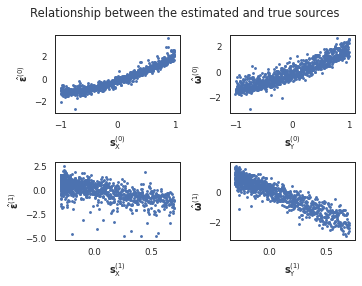

In [15]:
fig, axes = plt.subplots(z_dim, num_views)

for s in range(z_dim):
    for v in range(num_views):
        if v == 0:
            axes[s, v].scatter(S_x[s], NCA_Class.est_sources[v][s], s=4)
            xlab = '$\mathbf{s}_{\mathrm{X}}^{(' + str(s) + ')}$'
            ylab = r'$\hat{\mathbf{\varepsilon}}^{(' + str(s) + ')}$'
            axes[s, v].set_xlabel(xlab)
            axes[s, v].set_ylabel(ylab)
        elif v == 1:
            axes[s, v].scatter(S_y[s], NCA_Class.est_sources[v][s], s=4)
            xlab = '$\mathbf{s}_{\mathrm{Y}}^{(' + str(s) + ')}$'
            ylab = r'$\hat{\mathbf{\omega}}^{(' + str(s) + ')}$'
            axes[s, v].set_xlabel(xlab)
            axes[s, v].set_ylabel(ylab)

plt.suptitle('Relationship between the estimated and true sources')
plt.tight_layout()
plt.show()

## Correlation matrices

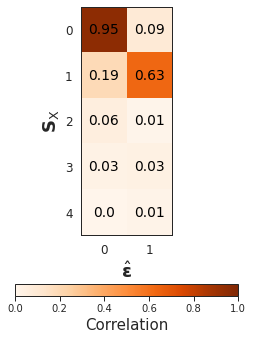

In [20]:
Cov_SE, dim1, dim2 = PCC_Matrix(tf.constant(S_x, tf.float32), NCA_Class.est_sources[0], samples)

fig, ax = plt.subplots(figsize=(4, 6))
legend = ax.imshow(Cov_SE, cmap='Oranges')
clrbr = plt.colorbar(legend, orientation="horizontal", pad=0.15)
for t in clrbr.ax.get_xticklabels():
    t.set_fontsize(10)
legend.set_clim(0, 1)
clrbr.set_label(r'Correlation', fontsize=15)
plt.xlabel(r'$\hat{\mathbf{\varepsilon}}$', fontsize=18)
plt.ylabel(r'$\mathbf{S}_{\mathrm{X}}$', fontsize=18)
plt.xticks(np.arange(0, dim2, 1), labels=np.arange(0, dim2, 1), fontsize=12)
plt.yticks(np.arange(0, dim1, 1), np.arange(0, dim1, 1), fontsize=12)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False)

for i in range(len(Cov_SE[0])):
    for j in range(len(Cov_SE)):
        c = np.around(Cov_SE[j, i], 2)
        txt = ax.text(i, j, str(c), va='center', ha='center', color='black', size='x-large')
        #txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()

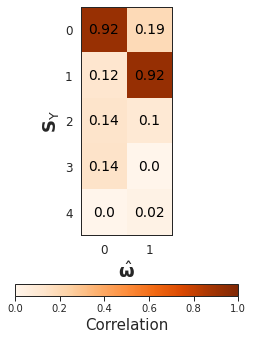

In [21]:
Cov_SO, dim1, dim2 = PCC_Matrix(tf.constant(S_y, tf.float32), NCA_Class.est_sources[1], samples)

fig, ax = plt.subplots(figsize=(4, 6))
legend = ax.imshow(Cov_SO, cmap='Oranges')
clrbr = plt.colorbar(legend, orientation="horizontal", pad=0.15)
for t in clrbr.ax.get_xticklabels():
    t.set_fontsize(10)
legend.set_clim(0, 1)
clrbr.set_label(r'Correlation', fontsize=15)
plt.xlabel(r'$\hat{\mathbf{\omega}}$', fontsize=18)
plt.ylabel(r'$\mathbf{S}_{\mathrm{Y}}$', fontsize=18)
plt.xticks(np.arange(0, dim2, 1), labels=np.arange(0, dim2, 1), fontsize=12)
plt.yticks(np.arange(0, dim1, 1), np.arange(0, dim1, 1), fontsize=12)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False)

for i in range(len(Cov_SO[0])):
    for j in range(len(Cov_SO)):
        c = np.around(Cov_SO[j, i], 2)
        txt = ax.text(i, j, str(c), va='center', ha='center', color='black', size='x-large')
        #txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

plt.show()